In [1]:
import os
import time
from importlib import reload

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import algos
import utils
reload(utils)

plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

# Some preparing

In [2]:
graphs = [utils.Graph.init(f'dataset/graph_{i}.txt') for i in range(1, 5)]

# 1. Find a way

In [3]:
def add_link(graph):
    for tag in [node.tag for node in graph.nodes]:
        if tag != 1:
            graph.add_edge(from_=tag, to_=1)
    return graph

def exp_increase(graph, func):
    iteration = 10
    damp_fac = .15

    print('Before link every nodes to node1')
    hits = algos.HITS(
        graph=graph,
        iteration=iteration)
    auth_list, hub_list = hits.get_auth_hub_list()
    print(f'HITS:\n\tAuthority:{auth_list}\n\tHub:      {hub_list}')

    pr = algos.PageRank(
        graph=graph,
        damping_factor=damp_fac,
        iteration=iteration)
    pr_list = pr.get_pr_arr()
    print('\nPR:\n\tPageRank:', pr_list)

    graph = func(graph)

    print('After link every nodes to node1')
    hits = algos.HITS(
        graph=graph,
        iteration=iteration)
    auth_list, hub_list = hits.get_auth_hub_list()
    print(f'HITS:\n\tAuthority:{auth_list}\n\tHub:      {hub_list}')

    pr = algos.PageRank(
        graph=graph,
        damping_factor=damp_fac,
        iteration=iteration)
    pr_list = pr.get_pr_arr()
    print('\nPR:\n\tPageRank:', pr_list, '\n\n')
    return graph

def find_a_way():
    for graph in graphs[:]:
        new_graph = exp_increase(graph, add_link)
        print('link addition:\n', new_graph.to_numpy())

# 2. Result analysis & discussion

## (1) damping factor

In [4]:
def exp_draw_damping_facs(graph, graph_id, iteration=100):
    results = []
    os.makedirs(f'images/damping_factor', exist_ok=True)
    damp_facs = np.arange(0.1, 1, 0.01)
    for damp_fac in damp_facs:

        pr = algos.PageRank(
            graph=graph,
            damping_factor=damp_fac,
            iteration=iteration)
        pr_list = pr.get_pr_arr()
        results.append(pr_list)

    result = np.stack(results)

    plt.plot(damp_facs, result)
    plt.title('Effection of decay factors(0.1 to 1 step by 0.01).')
    plt.xlabel('Damping Factor')
    plt.ylabel('Page Rank')
    plt.legend([f'node {node.tag}' for node in graph.nodes])
    plt.savefig(f'images/damping_factor/{graph_id}')
    plt.clf()

## (2) decay factor

In [5]:
def exp_draw_decay_facs(graph, graph_id, iteration=100):
    decay_fac = np.arange(0.1, 1, 0.1)
    os.makedirs(f'images/decay_factor/{graph_id}', exist_ok=True)

    for i, decay_fac in enumerate(decay_fac):
        sim = algos.Similarity(
            graph=graph,
            decay_fac=decay_fac)

        sr = algos.SimRank(
            graph=graph,
            iteration=iteration,
            sim=sim)

        sim_mat = sr.get_sim_matrix()

        img = sns.heatmap(sim_mat, annot=True, fmt=".2f")
        plt.title(f'Effection of decay factors ({decay_fac:.1f})')
        plt.savefig(f'images/decay_factor/{graph_id}/{i}')
        plt.clf()

# 3. Effectiveness analysis

In [8]:
def exp_run_time():
    def one_epoch(graph, graph_id, iteration, damp_fac, decay_fac):
        s = time.time()
        # HITS
        hits = algos.HITS(
            graph=graph,
            iteration=iteration)
        auth_list, hub_list = hits.get_auth_hub_list()
        # PageRank
        pr = algos.PageRank(
            graph=graph,
            damping_factor=damp_fac,
            iteration=iteration)
        pr_list = pr.get_pr_arr()
        # SimRank
        sim = algos.Similarity(
            graph=graph,
            decay_fac=decay_fac)
        sr = algos.SimRank(
            graph=graph,
            iteration=iteration,
            sim=sim)
        sim_mat = sr.get_sim_matrix()
        return time.time() - s

    results = []
    iters = np.arange(10, 1000, 10)
    for it in iters:
        result = []
        for i, graph in enumerate(graphs):
            result.append(
                one_epoch(graph, i+1, it, damp_fac=.1, decay_fac=.95))
        results.append(result)
    ans = np.array(results)
    plt.plot(iters, ans)
    plt.title('Effection of iteration(10 to 1000, step by 10)')
    plt.xlabel('iterations')
    plt.ylabel('costed time (sec)')
    plt.legend([f'graph_{i}' for i in np.arange(1, 5)])

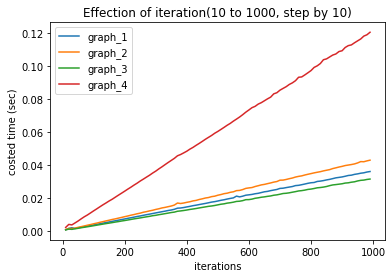

In [9]:
exp_run_time()